In [1]:
# Modified from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
from skimage import io, transform

plt.ion()   # interactive mode

In [2]:
class FaceFaceDataset_cb(Dataset):
    """FaceFace dataset."""

    def __init__(self, folders, transform=None):
        """
        Args:
            root_dir (string): Path to the root directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.folders = folders
        self.transform = transform     
        self.images = []
        for fd in self.folders:
            for f in os.listdir(fd):
                if not f.startswith('.') and f.endswith('jpg'):
                    if 'real' in fd:
                        self.images.append((fd + '/' + f, 1))
                    else:
                        self.images.append((fd + '/' + f, 0))
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = io.imread(self.images[idx][0])
        
        if self.transform:
            image = F.to_pil_image(image)
            image = self.transform(image)
        target   = self.images[idx][1]
        return (image, target, self.images[idx][0])
    

class FaceFaceDataset_cfd(Dataset):
    """FaceFace dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Path to the root directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        self.images = []
        for tp in ['real', 'fake']:
            working_dir = os.path.join(root_dir, tp)
            if tp == "fake":                
                for f in os.listdir(working_dir):
                    if not f.startswith('.') and f.endswith('jpg'):
                        self.images.append((working_dir+ '/' + f, 0))
            else:
                for fd in os.listdir(working_dir):
                    if os.path.isdir(os.path.join(working_dir, fd)):
                        for f in os.listdir(os.path.join(working_dir, fd)):
                            if not f.startswith('.') and f.endswith('jpg') and 'N' in f:
                                self.images.append((working_dir+ '/' + fd + '/' + f, 1))
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = io.imread(self.images[idx][0])
        
        if self.transform:
            image = F.to_pil_image(image)
            image = self.transform(image)
        target   = self.images[idx][1]
        return (image, target, self.images[idx][0])
    

In [3]:
folders = []

root_dir = '/media/xinyi/Samsung_T3/FakeFace Dataset/faceface data/'

for tv in ['train', 'val']:
    for m in ['autoencoder', 'pipeline']:
        for tp in ['real', 'fake']:
            working_dir = os.path.join(root_dir, tv + '/' + tp + '/' + m)
            for fd in os.listdir(working_dir):
                if os.path.isdir(os.path.join(working_dir, fd)):
                    folders.append(os.path.join(working_dir, fd))

folders = np.array(folders)


In [4]:
transformed_train_dataset = FaceFaceDataset_cb(folders=folders,
                                      transform=transforms.Compose([
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                           ]))

transformed_val_dataset = FaceFaceDataset_cfd(root_dir='/media/xinyi/Samsung_T3/FakeFace Dataset/cfd_images',
                                      transform=transforms.Compose([
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                          
                                           ]))

In [5]:
dataloader_train = DataLoader(transformed_train_dataset, batch_size=16,
                        shuffle=True, num_workers=8)
dataloader_val = DataLoader(transformed_val_dataset, batch_size=16,
                        shuffle=True, num_workers=8)

dataset_sizes = {'train': len(transformed_train_dataset), 'val': len(transformed_val_dataset)}
dataloaders = {'train': dataloader_train, 'val': dataloader_val}

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = transformed_train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(dataset_sizes)

True
{'train': 416329, 'val': 1208}


torch.Size([16, 3, 224, 224])


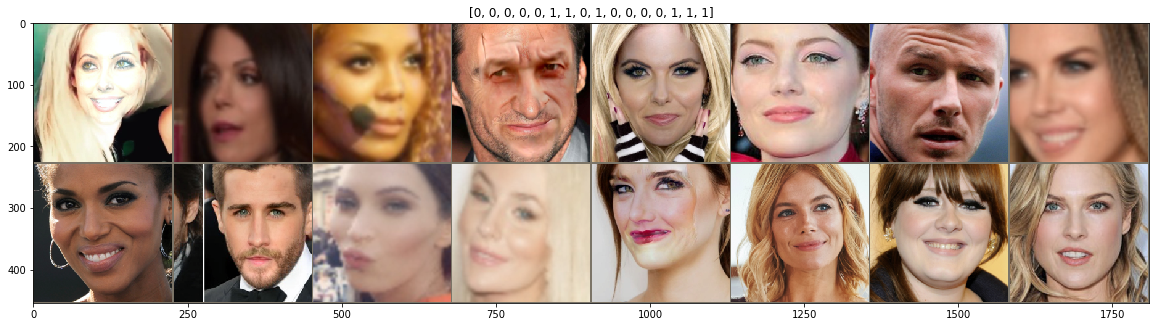

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes, file_names = next(iter(dataloaders['train']))

print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x.item() for x in classes])
# print(file_names)

In [42]:
def log_data(preds, actual_labels, names, epoch):
    with open(str(epoch) + '_preds.txt', 'a') as the_file:
        lo = ''
        for i, p in enumerate(preds):
            lo = str(p.item()) + ',' + str(actual_labels[i].item()) + ',' + str(names[i])
            the_file.write(lo + '\n')
        
def log_raw(outputs, actual_labels, names, epoch, itr_run=0):
    with open(str(itr_run) + '_' + str(epoch) + '_outputs.txt', 'a') as the_file:
        lo = ''
        for i, o in enumerate(outputs):
            lo = str(actual_labels[i].item()) + ',' +  str(o[0].item()) + ',' + str(o[1].item()) + ',' + str(names[i])
            the_file.write(lo + '\n')


def train_model(model, criterion, optimizer, scheduler, num_epochs=25, itr_run=0):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            i = 0
            for inputs, labels, files in dataloaders[phase]:
                i = i + 1
                if i % 1000 == 0:
                    print('Epoch {}/{}: {}/{} '.format(epoch, num_epochs - 1, i, len(dataloaders[phase])))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else: # Write ouput to file
                        log_data(preds, labels.data, files, epoch)
                        log_raw(outputs, labels.data, files, epoch, itr_run)
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [43]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [44]:
ts = time.time()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5, itr_run=ts)

Epoch 0/4
----------
Epoch 0/4: 1000/26021 
Epoch 0/4: 2000/26021 
Epoch 0/4: 3000/26021 
Epoch 0/4: 4000/26021 
Epoch 0/4: 5000/26021 
Epoch 0/4: 6000/26021 
Epoch 0/4: 7000/26021 
Epoch 0/4: 8000/26021 
Epoch 0/4: 9000/26021 
Epoch 0/4: 10000/26021 
Epoch 0/4: 11000/26021 
Epoch 0/4: 12000/26021 
Epoch 0/4: 13000/26021 
Epoch 0/4: 14000/26021 
Epoch 0/4: 15000/26021 
Epoch 0/4: 16000/26021 
Epoch 0/4: 17000/26021 
Epoch 0/4: 18000/26021 
Epoch 0/4: 19000/26021 
Epoch 0/4: 20000/26021 
Epoch 0/4: 21000/26021 
Epoch 0/4: 22000/26021 
Epoch 0/4: 23000/26021 
Epoch 0/4: 24000/26021 
Epoch 0/4: 25000/26021 
Epoch 0/4: 26000/26021 
train Loss: 0.0786 Acc: 0.9701
val Loss: 0.3624 Acc: 0.8444

Epoch 1/4
----------
Epoch 1/4: 1000/26021 
Epoch 1/4: 2000/26021 
Epoch 1/4: 3000/26021 
Epoch 1/4: 4000/26021 
Epoch 1/4: 5000/26021 
Epoch 1/4: 6000/26021 
Epoch 1/4: 7000/26021 
Epoch 1/4: 8000/26021 
Epoch 1/4: 9000/26021 
Epoch 1/4: 10000/26021 
Epoch 1/4: 11000/26021 
Epoch 1/4: 12000/26021 
Epo

In [9]:
torch.save(model_ft.state_dict(), './' + str(ts)+'_best_model.pth')